In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os

In [7]:
print (os.getcwd())

/Users/fytian/Desktop/nus school years/year4/ec4305/ec4305report


In [8]:
# loading all datasets

# FRED data loader
def load_fred_csv(path):
    df = pd.read_csv(path)
    # Set date
    df['date'] = pd.to_datetime(df['observation_date'])
    df = df.set_index('date')
    df = df.drop('observation_date', axis=1)
    return df

# FRED data #
beef = load_fred_csv("../data/PBEEFUSDM.csv")
corn = load_fred_csv("../data/PMAIZMTUSDM.csv")
pork = load_fred_csv("../data/PPORKUSDM.csv")
lamb = load_fred_csv("../data/PLAMBUSDM.csv")
chicken = load_fred_csv("../data/PPOULTUSDM.csv")
oil = load_fred_csv("../data/POILBREUSDM.csv")
usd = load_fred_csv("../data/RTWEXBGS_PCH.csv")

# FAO Food Price Index #
food_raw = pd.read_excel(
    "../data/food_price_indices.xlsx",
    sheet_name=2,          # third sheet
    header=2,              # skip title rows
    dtype=str,             # force all cells as string to prevent issues
    converters={
        "Month": str, # force Month as string
        "Food Price Index": lambda x: pd.to_numeric(x, errors='coerce'),
        "Meat Price Index": lambda x: pd.to_numeric(x, errors='coerce'),
        "Dairy Price Index": lambda x: pd.to_numeric(x, errors='coerce'),
        "Cereals Price Index": lambda x: pd.to_numeric(x, errors='coerce'),
        "Oils Price Index": lambda x: pd.to_numeric(x, errors='coerce'),
        "Sugar Price Index": lambda x: pd.to_numeric(x, errors='coerce')
    }
)


food_raw.columns = food_raw.columns.str.strip()
food_raw = food_raw[food_raw["Month"].notna()]
food_raw["Month"] = food_raw["Month"].str.strip()


food_raw["Month"] = food_raw["Month"].str.slice(0, 7)
food_raw["Month"] = food_raw["Month"].str.replace("/", "-", regex=False)
food_raw["date"] = pd.to_datetime(
    food_raw["Month"],
    format="%Y-%m",
    errors="coerce"
)

food_raw = food_raw.dropna(subset=["date"])
food_index = food_raw.set_index("date")
food_index = food_index.drop(columns=["Month"])

# keep only Food Price Index
food_index = food_index[["Food Price Index"]].rename(
    columns={"Food Price Index": "fao_food_index"}
)

food_index.index = pd.to_datetime(food_index.index, errors="coerce")
food_index = food_index[~food_index.index.isna()]
food_index.index = food_index.index.to_period("M")
food_index.index = food_index.index.to_timestamp(how="start")
food_index = food_index[~food_index.index.duplicated(keep="first")]

# Drought data #
us_drought = pd.read_csv("../data/us_drought.csv")

date_col = "Month"
us_drought[date_col] = pd.to_datetime(us_drought[date_col])
us_drought = us_drought.set_index(date_col)
us_drought.index = us_drought.index.to_period("M").to_timestamp(how="start")
us_drought = us_drought.sort_index()
us_drought = us_drought[~us_drought.index.duplicated(keep="first")]

# Fill NaN values in D0-D4 columns with 0 before joining
drought_columns = ['None', 'D0', 'D1', 'D2', 'D3', 'D4']
us_drought[drought_columns] = us_drought[drought_columns].fillna(0)

brazil_drought = pd.read_csv("../data/brazil_drought.csv")
brazil_drought["date"] = pd.to_datetime(brazil_drought["date"])
brazil_drought = brazil_drought.set_index("date")

# ENSO Data (Sea Temps) #
enso = pd.read_csv("../data/ncep_noaa_seatemp.txt",
                   sep='\\s+',
                   names=["YR","MON","TOTAL","ClimAdjust","ANOM"],
                   comment="#",
                   skiprows=1
                  )

enso['date'] = pd.to_datetime(dict(year=enso.YR, month=enso.MON, day=1))
enso = enso.set_index('date')
enso = enso[['ANOM']].rename(columns={'ANOM': 'enso_anomaly'}) # only keep anomaly

FileNotFoundError: [Errno 2] No such file or directory: '../data/PBEEFUSDM.csv'

In [ ]:
df = (corn
      .join(beef, how="outer")
      .join(pork, how="outer")
      .join(lamb, how="outer")
      .join(chicken, how="outer")
      .join(oil, how="outer")
      #.join(usd, how="outer") 
      .join(food_index, how="outer")
      .join(us_drought, how="outer")
      .join(brazil_drought, how="outer")
      .join(enso, how="outer")
     )

df.index = pd.to_datetime(df.index)
df = df.sort_index()

print(f"Initial shape after joins and sorting: {df.shape}")


df_clean = df.dropna(how="any")
print(f"Shape after dropping rows with any missing values: {df_clean.shape}")

index_as_periods = df_clean.index.to_period('M')
diff_in_months = (index_as_periods.year * 12 + index_as_periods.month).to_series().diff().fillna(1)

longest_segment_start = None
longest_segment_end = None
max_length = 0
current_segment_start_index = 0

if not df_clean.empty:
    for i in range(1, len(df_clean.index)):
        if diff_in_months.iloc[i] != 1:
            current_segment_length = i - current_segment_start_index
            if current_segment_length > max_length:
                max_length = current_segment_length
                longest_segment_start = df_clean.index[current_segment_start_index]
                longest_segment_end = df_clean.index[i-1]
            current_segment_start_index = i

    current_segment_length = len(df_clean.index) - current_segment_start_index
    if current_segment_length > max_length:
        max_length = current_segment_length
        longest_segment_start = df_clean.index[current_segment_start_index]
        longest_segment_end = df_clean.index[len(df_clean.index)-1]

if longest_segment_start is None and not df_clean.empty:
    longest_segment_start = df_clean.index.min()
    longest_segment_end = df_clean.index.max()
    max_length = len(df_clean.index)

# filter df_clean to the longest continuous segment
df_clean = df_clean.loc[longest_segment_start:longest_segment_end]

print(f"Shape of the finalized continuous df_clean: {df_clean.shape}")
print(f"Final continuous date range: {df_clean.index.min()} \u2192 {df_clean.index.max()}")

display(df_clean.head())

# confirm no missing values in the final df_clean
na_counts_final = df_clean.isna().sum().sort_values(ascending=False)
print("\nMissing values per column in the finalized df_clean:\n")
print(na_counts_final)

if na_counts_final.sum() == 0:
    print("\n\u2714 No missing values found in the final df_clean. The DataFrame is clean and continuous.")
else:
    print("\n\u2718 Missing values still exist in the final df_clean. Investigation needed.")

Initial shape after joins and sorting: (910, 17)
Shape after dropping rows with any missing values: (242, 17)
Shape of the finalized continuous df_clean: (242, 17)
Final continuous date range: 2002-11-01 00:00:00 → 2022-12-01 00:00:00


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,None,D0,D1,D2,D3,D4,cdd,cwd,pr,enso_anomaly
2002-11-01,108.646429,81.5625,40.602105,154.961183,61.904762,24.250476,74.87733797848195,51.40,13.67,13.34,10.76,10.09,0.74,7.33,11.23,140.41,1.41
2002-12-01,107.012648,84.0000,43.672000,157.936380,61.488636,28.317273,74.06157497027121,54.92,11.42,9.53,12.85,10.44,0.84,5.91,15.81,218.97,1.31
2003-01-01,105.844256,85.3500,46.583500,162.690205,62.253623,30.808696,70.67080253240994,48.40,14.97,10.42,8.95,15.26,2.00,4.71,14.25,219.03,0.70
2003-02-01,106.141080,83.7500,48.164211,159.704332,63.062500,32.662500,71.45461420663185,47.96,14.75,10.33,10.24,14.99,1.73,4.51,17.08,207.76,0.74
2003-03-01,105.131879,83.8750,48.838500,153.104803,63.841270,30.168095,70.26923771734234,46.41,17.11,11.86,11.82,12.34,0.46,3.88,20.04,236.61,0.45



Missing values per column in the finalized df_clean:

PMAIZMTUSDM       0
D1                0
pr                0
cwd               0
cdd               0
D4                0
D3                0
D2                0
D0                0
PBEEFUSDM         0
None              0
fao_food_index    0
POILBREUSDM       0
PPOULTUSDM        0
PLAMBUSDM         0
PPORKUSDM         0
enso_anomaly      0
dtype: int64

✔ No missing values found in the final df_clean. The DataFrame is clean and continuous.


## EDA & Pre-processing

Summary Statistics for df_clean:


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,None,D0,D1,D2,D3,D4,cdd,cwd,pr,enso_anomaly
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,188.316069,168.389331,72.104522,134.927993,101.695594,71.249873,56.641612,17.014174,10.885000,8.215785,4.889793,1.705785,10.222603,11.426694,147.000702,-0.085537
std,67.223973,48.349486,16.821360,26.345812,29.969954,27.102952,13.073507,4.975288,3.816214,4.850147,4.026209,2.160655,5.984585,5.219994,73.263905,0.833040
min,93.415148,78.250000,40.602105,86.119095,61.488636,24.250476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.380000,2.900000,33.160000,-1.690000
25%,150.702291,119.700000,58.957083,110.918264,80.799513,50.412490,49.277500,13.440000,8.155000,4.472500,1.277500,0.060000,4.782500,6.710000,71.082500,-0.700000
50%,166.708197,180.114130,69.867857,140.139116,94.610795,66.560227,57.080000,17.505000,11.005000,7.440000,4.300000,0.960000,8.310000,11.505000,149.900000,-0.175000
75%,235.567209,195.421690,81.280574,155.711640,114.214109,93.471769,65.207500,20.900000,13.365000,11.265000,7.942500,2.447500,15.535000,16.220000,212.805000,0.447500
max,348.507117,275.304348,128.667727,186.588721,227.963324,133.585217,89.590000,29.690000,22.080000,22.270000,16.100000,9.970000,23.340000,23.380000,288.100000,2.710000



Visualizing US Drought Severities:


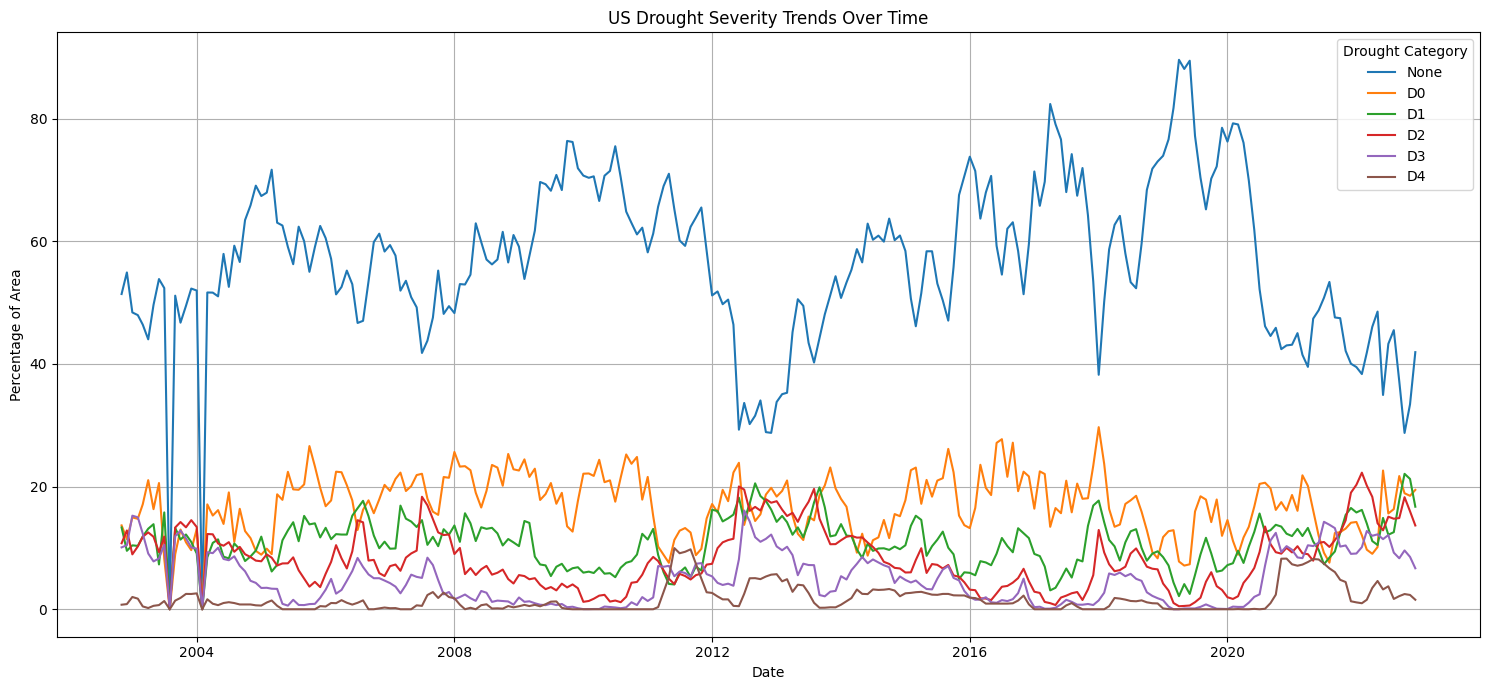

In [7]:
print("Summary Statistics for df_clean:")
display(df_clean.describe())

print("\nVisualizing US Drought Severities:")
drought_cols = ['None', 'D0', 'D1', 'D2', 'D3', 'D4']

plt.figure(figsize=(15, 7))
for col in drought_cols:
    plt.plot(df_clean.index, df_clean[col], label=col)

plt.title('US Drought Severity Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Area')
plt.legend(title='Drought Category')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
 # ADF Test for stationarity of price variables #
price_variables = [
  'PMAIZMTUSDM',   # Corn Price
  'PBEEFUSDM',     # Beef Price
  'PPORKUSDM',     # Pork Price
  'PLAMBUSDM',     # Lamb Price
  'PPOULTUSDM',    # Poultry Price
  'POILBREUSDM',   # Oil Price
  'fao_food_index' # FAO Food Price Index
]


In [9]:
def fractional_differencing(series, d):
    n_samples = len(series)

    # calculate weights for fractional differencing
    weights = [1.0]
    for k in range(1, n_samples):
        weights.append(-weights[-1] * (d - k + 1) / k)
    weights = np.array(weights)

    frac_diff_series = pd.Series(index=series.index, dtype=float)
    for i in range(n_samples):
        # need at least k previous values -> iterate up to i

        if i < len(weights):
            frac_diff_series.iloc[i] = np.dot(weights[:i+1], series.iloc[i::-1])

    return frac_diff_series.dropna()

In [10]:
def run_adf_test(series, label):
    print(f"\n--- ADF Test for {label} Series ---")
    if series.isnull().any():
        print("Warning: Series contains NaN values. Dropping NaNs for ADF test.")
        series = series.dropna()
    if len(series) < 5:
        print(f"Warning: Series has too few observations ({len(series)}) for reliable ADF test. Skipping.")
        return 1.0

    adf_result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')

    if adf_result[1] <= 0.05:
        print(f'The {label} series is likely stationary (p-value <= 0.05).')
    else:
        print(f'The {label} series is likely non-stationary (p-value > 0.05).')
    return adf_result[1]

# iterate through each price variable
for variable in price_variables:
    print(f"\n{'='*50}")
    print(f"Analyzing Variable: {variable}")
    print(f"{'='*50}")

    original_series = df_clean[variable].astype(float) # Ensure the series is numeric

    # test original series
    p_value_original = run_adf_test(original_series, 'Original')

    # non-stationary -> apply fractional differencing w d = 0.5
    if p_value_original > 0.05:
        frac_diff_series = fractional_differencing(original_series, d=0.5)

        if not frac_diff_series.empty:
            run_adf_test(frac_diff_series, 'Fractionally Differenced (d=0.5)')
        else:
            print(f"Warning: Fractionally differenced series for '{variable}' is empty. Cannot perform ADF test.")
    else:
        print(f"\nOriginal series '{variable}' is already stationary. No differencing applied.")


Analyzing Variable: PMAIZMTUSDM

--- ADF Test for Original Series ---
ADF Statistic: -1.8987
p-value: 0.3327
Critical Values:
	1%: -3.4579
	5%: -2.8737
	10%: -2.5732
The Original series is likely non-stationary (p-value > 0.05).

--- ADF Test for Fractionally Differenced (d=0.5) Series ---
ADF Statistic: -6.7062
p-value: 0.0000
Critical Values:
	1%: -3.4578
	5%: -2.8736
	10%: -2.5732
The Fractionally Differenced (d=0.5) series is likely stationary (p-value <= 0.05).

Analyzing Variable: PBEEFUSDM

--- ADF Test for Original Series ---
ADF Statistic: -1.8219
p-value: 0.3697
Critical Values:
	1%: -3.4582
	5%: -2.8738
	10%: -2.5733
The Original series is likely non-stationary (p-value > 0.05).

--- ADF Test for Fractionally Differenced (d=0.5) Series ---
ADF Statistic: -5.8563
p-value: 0.0000
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
The Fractionally Differenced (d=0.5) series is likely stationary (p-value <= 0.05).

Analyzing Variable: PPORKUSDM

--- ADF Test for Original 

In [11]:
stationarity_summary = []

for variable in price_variables:
    original_series = df_clean[variable].astype(float)

    # Test original series
    adf_result_original = adfuller(original_series, autolag='AIC')
    p_value_original = adf_result_original[1]
    conclusion_original = 'Stationary' if p_value_original <= 0.05 else 'Non-stationary'

    stationarity_summary.append({
        'Variable': variable,
        'Transformation': 'Original',
        'P-value': f'{p_value_original:.4f}',
        'Conclusion': conclusion_original
    })

    # Apply fractional differencing if non-stationary
    if p_value_original > 0.05:
        frac_diff_series = fractional_differencing(original_series, d=0.5)
        if not frac_diff_series.empty:
            adf_result_frac_diff = adfuller(frac_diff_series, autolag='AIC')
            p_value_frac_diff = adf_result_frac_diff[1]
            conclusion_frac_diff = 'Stationary' if p_value_frac_diff <= 0.05 else 'Non-stationary'

            stationarity_summary.append({
                'Variable': variable,
                'Transformation': 'Fractionally Differenced (d=0.5)',
                'P-value': f'{p_value_frac_diff:.4f}',
                'Conclusion': conclusion_frac_diff
            })
        else:
            stationarity_summary.append({
                'Variable': variable,
                'Transformation': 'Fractionally Differenced (d=0.5)',
                'P-value': 'N/A',
                'Conclusion': 'Series empty after differencing'
            })

# Convert the summary to a DataFrame and display
summary_df = pd.DataFrame(stationarity_summary)
print("\nSummary of Stationarity Tests:")
display(summary_df)


Summary of Stationarity Tests:


,Variable,Transformation,P-value,Conclusion
0,PMAIZMTUSDM,Original,0.3327,Non-stationary
1,PMAIZMTUSDM,Fractionally Differenced (d=0.5),0.0000,Stationary
2,PBEEFUSDM,Original,0.3697,Non-stationary
3,PBEEFUSDM,Fractionally Differenced (d=0.5),0.0000,Stationary
4,PPORKUSDM,Original,0.0001,Stationary
5,PLAMBUSDM,Original,0.1239,Non-stationary
6,PLAMBUSDM,Fractionally Differenced (d=0.5),0.0000,Stationary
7,PPOULTUSDM,Original,0.8321,Non-stationary
8,PPOULTUSDM,Fractionally Differenced (d=0.5),0.0107,Stationary
9,POILBREUSDM,Original,0.0461,Stationary


In [ ]:
# scatter plots of PBEEFUSDM against other features 

all_columns = df_clean.columns.tolist()
features_to_plot = [col for col in all_columns if col != 'PBEEFUSDM']

num_features = len(features_to_plot)
rows = int(np.ceil(num_features / 3))  # 3 plots per row
cols = 3

plt.figure(figsize=(18, 5 * rows)) 

for i, feature in enumerate(features_to_plot):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(x=df_clean[feature], y=df_clean['PBEEFUSDM'])
    plt.title(f'PBEEFUSDM vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('PBEEFUSDM')
    plt.grid(True)

plt.tight_layout()
plt.show()

Features identified for plotting (excluding PBEEFUSDM):
['PMAIZMTUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'cdd', 'cwd', 'pr', 'enso_anomaly']


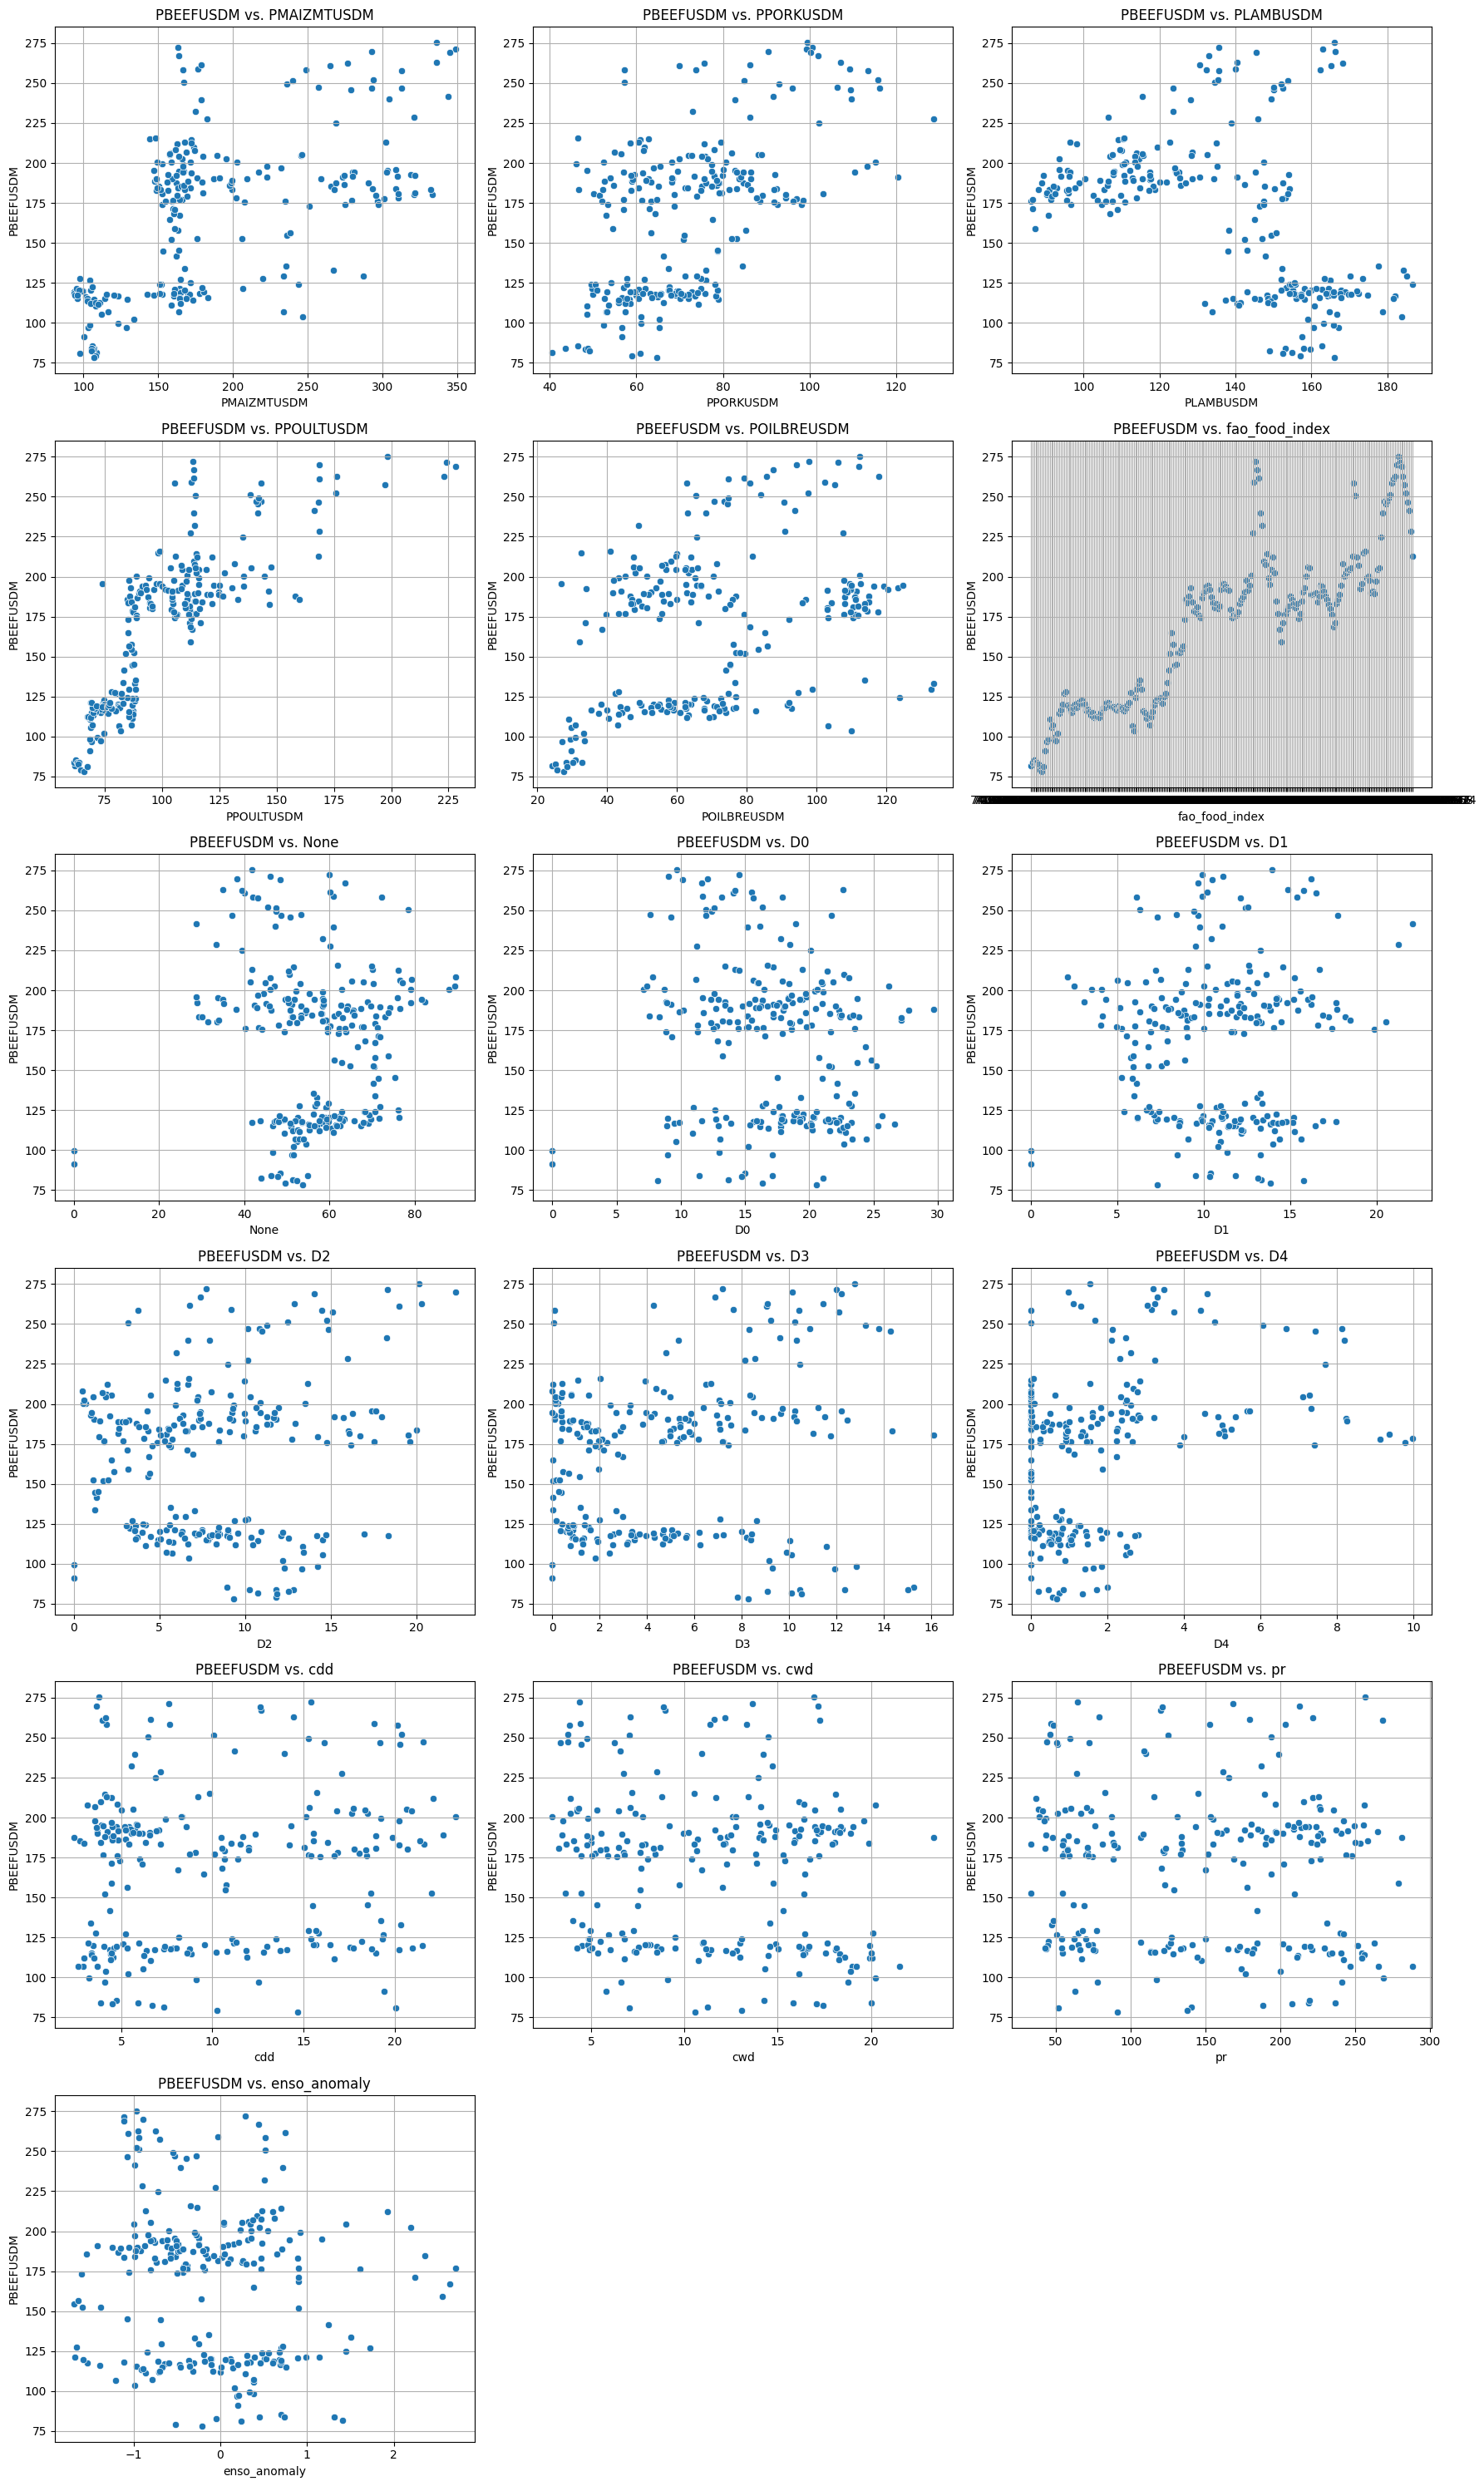